# Lab 8: Time-series analysis

### MAE 3120, Spring 2022

**Caden Gobat and Jade Greenberg**

**Abstract/introduction:** Time-resolved data is prevalent in almost every field of science and engineering, and techniques to analyze it properly are critical for understanding and predicting the behaviors of the systems that produce it. Here, the system we will explore is the global climate, and how its temperature has changed over the last several decades. Through regression and inferential statistics, we can identify trends, predict future values, and make judgements based on this information. In this lab, we will walk through this analysis process from data exploration to predictive modeling.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats,optimize
try:
    import statsmodels.api as sm
except:
    !pip install --upgrade pip statsmodels
    import statsmodels.api as sm

## Load data

Create some useful derived features (columns) and display the resulting table.

In [2]:
Tm = pd.read_csv("./GlobalTemperatureAnomaly-1958-2008.csv",header=None,names=["Time","T"])
print(Tm.shape)
Tm["Year"] = [int(yr) for yr in Tm["Time"]] # add a column for integer year
Tm["t"] = Tm["Time"]-1958 # horizontal axis variable starting from 0 for regression purposes
display(Tm)

(612, 2)


,Time,T,Year,t
0,1958.00,0.2673,1958,0.00
1,1958.08,0.0792,1958,0.08
2,1958.17,-0.0418,1958,0.17
3,1958.25,-0.1092,1958,0.25
4,1958.33,-0.2051,1958,0.33
...,...,...,...,...
607,2008.58,0.3587,2008,50.58
608,2008.67,0.3838,2008,50.67
609,2008.75,0.4074,2008,50.75
610,2008.83,0.4513,2008,50.83


## Part I

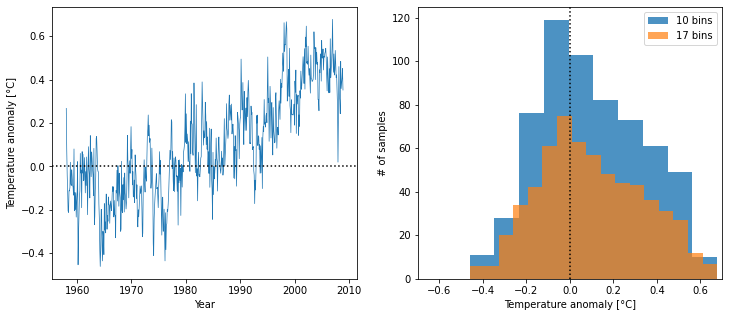

In [3]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
axs[0].plot(Tm["Time"],Tm["T"],linewidth=0.7)
axs[0].set(xlabel="Year",ylabel="Temperature anomaly [°C]")
axs[0].axhline(0,linestyle=":",color="k")
axs[1].hist(Tm["T"],bins=10,alpha=0.8,label="10 bins")
axs[1].hist(Tm["T"],bins=17,alpha=0.7,label="17 bins")
axs[1].set(xlabel="Temperature anomaly [°C]",ylabel="# of samples",xlim=(-.7,.7))
axs[1].axvline(0,linestyle=":",color="k")
axs[1].legend()
plt.show()

In [4]:
print(f"Sturgis: {1+3.3*np.log10(len(Tm)):.0f}")
print(f"Rice:\t {2*len(Tm)**(1/3):.0f}")

Sturgis: 10
Rice:	 17


Visual inspection of the time-series graph reveals an apparently increasing behavior over time. Further statistical analysis will be necessary to determine whether the trend is signficant.

The histogram does not appear symmetric about its peak (i.e. the distribution does not appear normal), with a skew towards the right (positive) side. The Sturgis rule says that for $n=612$ data points, we should use approximately 10 bins. The Rice rule gives us a recommendation of about 17 bins. Both are shown in the histogram above.

In [5]:
print("Statistical summary of data:")
print(Tm["T"].describe())

Statistical summary of data:
count    612.000000
mean       0.099796
std        0.239514
min       -0.461100
25%       -0.084400
50%        0.073650
75%        0.280475
max        0.677600
Name: T, dtype: float64


## Part II

m = 0.0131±0.0004	b = -0.2326±0.0115
Mean residual: -7.256359638072919e-18 ± 0.1425263532424672


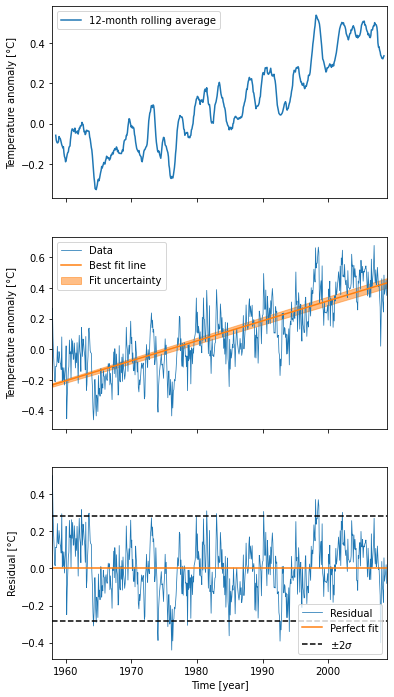

In [6]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(6,12),sharex=True)
x = Tm["Time"].values - Tm["Time"].values[0]
axs[0].plot(Tm["Time"],Tm["T"].rolling(window=12,center=True).mean(),label="12-month rolling average")
axs[0].set(ylabel="Temperature anomaly [°C]")
axs[0].legend()
model = lambda x,m,b : m*x + b
(m,b), cov = optimize.curve_fit(model,x,Tm["T"],p0=[.1,0])
m_err,b_err = np.sqrt(np.diag(cov))
print(f"m = {m:.4f}±{m_err:.4f}\tb = {b:.4f}±{b_err:.4f}")
axs[1].plot(Tm["Time"],Tm["T"],linewidth=0.75,label="Data")
axs[1].plot(Tm["Time"],m*x+b,label="Best fit line")
axs[1].fill_between(Tm["Time"],(m-m_err)*x+(b-b_err),
                    (m+m_err)*x+(b+b_err),
                    color="C1",alpha=0.5,label="Fit uncertainty")
axs[1].legend()
axs[1].set(ylabel="Temperature anomaly [°C]")
resid = Tm["T"] - (m*x+b)
err_mean,sig = stats.norm.fit(resid)
print(f"Mean residual: {err_mean} ± {sig}")
axs[2].plot(Tm["Time"],resid,linewidth=0.75,label="Residual")
axs[2].axhline(err_mean,color="C1",label="Perfect fit")
axs[2].axhline(2*sig,color="k",linestyle="--",label=r"$\pm2\sigma$")
axs[2].axhline(-2*sig,color="k",linestyle="--")
axs[2].legend()
axs[2].set(xlabel="Time [year]",xlim=(1958,2009),ylabel="Residual [°C]")
plt.show()

There does appear to be a clear trend in the data, though it is only slightly more apparent than it was prior to smoothing.

If $\pm 2\sigma$ around the trend line appropriately captures the confidence interval of the fitted model, then anything outside those values represents an outlier. However, we need to investigate further to know if this is the case.

The residuals do look correlated because the behavior of a given residual value is related to the values around it (for example, if a given data point lies below the trendline, the values around it are likely to be below the line as well, and vice versa).

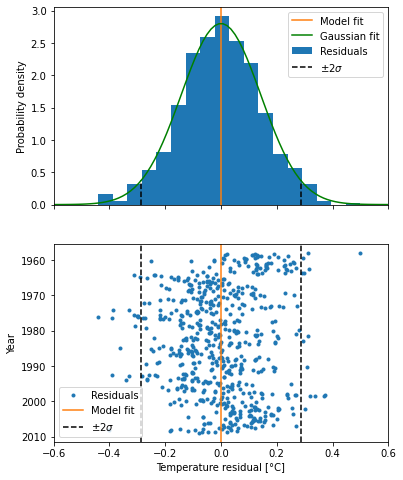

In [7]:
fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(6,8),sharex=True)
r = np.linspace(-5*sig,5*sig,100)
axs[0].hist(resid,18,density=True,label="Residuals")
axs[0].axvline(np.mean(resid),color="C1",label="Model fit")
axs[0].vlines([-2*sig,2*sig],0,stats.norm.pdf(2*sig,err_mean,sig),color="k",linestyle="--",label=r"$\pm2\sigma$")
axs[0].plot(r,stats.norm.pdf(r,err_mean,sig),"g-",label="Gaussian fit")
axs[0].legend()
axs[0].set_ylabel("Probability density")
axs[1].plot(resid,Tm["Time"],".",label="Residuals")
axs[1].invert_yaxis()
axs[1].axvline(np.mean(resid),color="C1",label="Model fit")
axs[1].axvline(2*sig,color="k",linestyle="--",label=r"$\pm2\sigma$")
axs[1].axvline(-2*sig,color="k",linestyle="--")
axs[1].legend()
axs[1].set(xlim=(-.6,.6),xlabel="Temperature residual [°C]",ylabel="Year")
plt.show()

The distribution of residuals appears pretty Gaussian, with a mean of approximately 0 (as desired).

## Part III

Pearson's r = 0.6667321066524987
ACF at lag 1: 0.6598076398972831


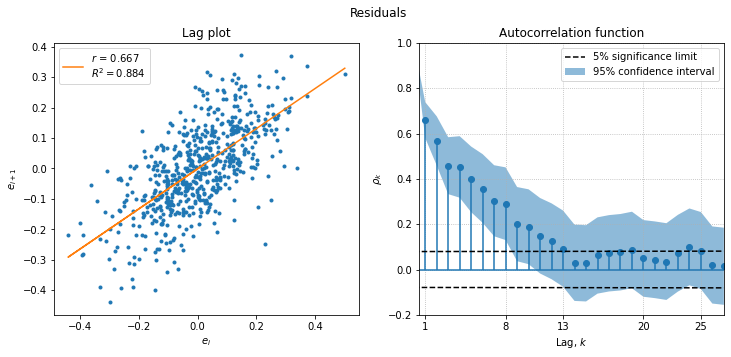

In [8]:
x = resid[:-1]
y = resid[[i+1 for i in range(len(resid)-1)]]

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

axs[0].plot(x,y,".")
m,b = np.polyfit(x,y,1)
R_sq = 1 - np.var(y - (m*x+b))/np.var(y)
r = np.corrcoef(x,y)[0,1]
print(f"Pearson's r = {r}")
axs[0].plot(x,m*x+b,label=f"$r$ = {r:.3f}\n$R^2="+str(round(R_sq,3))+"$")
axs[0].legend()
# axs[0].set_xlim(x.min(),x.max())
axs[0].set_xlabel(r"$e_i$")
axs[0].set_ylabel(r"$e_{i+1}$")
axs[0].set_title("Lag plot")

ac,conf = sm.tsa.acf(resid,alpha=0.05,fft=False) # return ACF and 95% confidence interval
ci95 = 1.96/np.sqrt(len(resid)-np.arange(len(ac))) # 95% significance values
print("ACF at lag 1:",ac[1])
axs[1].stem(ac,basefmt="")#,label="Autocorrelation coefficients")
axs[1].fill_between(np.arange(len(ac)),conf[:,0],conf[:,1],alpha=0.5,label="95% confidence interval")
axs[1].plot(ci95,"k--",label="5% significance limit")
axs[1].plot(-ci95,"k--")
axs[1].set_xticks([1,8,13,20,25])
axs[1].grid(linestyle=":")
# axs[1].axhline(r,label=f"$r$={r:.3f} (lag 1 correlation)")
axs[1].set_xlim(0.5,27)
axs[1].set_ylim(-0.2,1)
axs[1].set_xlabel("Lag, $k$")
axs[1].set_ylabel(r"$\rho_k$")
axs[1].set_title("Autocorrelation function")
axs[1].legend()

fig.suptitle("Residuals")
plt.show()

We see that the values themselves of the autocorrelation function are at or above the $\alpha=0.05$ level of significance up to lag $k=13$. If we take into account the error (95\% confidence interval) on the $\rho_k$ themselves, then we can confidently say that we have statistically significant autocorrelation up to lag $k=8$ (the last value for which the confidence region lies entirely outside the dashed black lines).

In [9]:
N = len(resid)
z = lambda r : 0.5*np.log((1+r)/(1-r))
def conf_r(x,y,c=0.95):
    a = 1-c
    df = pd.DataFrame(np.column_stack([x,y]),columns=["x","y"])
    n = len(df)
    r = df.corr().loc["x","y"]
    zr = z(r)
    zL = zr - z(1-a/2)/np.sqrt(n-3)
    zU = zr + z(1-a/2)/np.sqrt(n-3)
    rL = (np.exp(2*zL)-1)/(np.exp(2*zL)+1)
    rU = (np.exp(2*zU)-1)/(np.exp(2*zU)+1)
    return rL,r,rU
conf_r(x,y)

(0.6145714476815413, 0.6667321066524984, 0.7130881731567736)

We can therefore report (with 95\% confidence) that the correlation coefficient of the lag data lies within the interval $(0.615,0.713)$. In other words, we report a Pearson's $r$ of $0.667_{-0.052}^{+0.046}$.

## Part IV

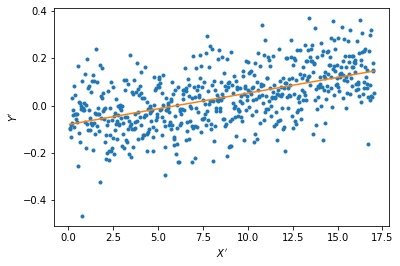

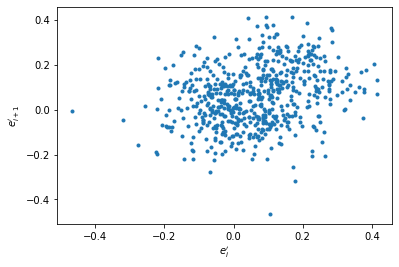

Original residual r = 0.6667321066517482
Transformed residual r'= 0.266536974444703
0.013058184834508671 -0.23264370721252006
0.013316313418787733 -0.2419874045444846


In [10]:
def cochrane_orcutt(X,Y,m,b):
    
    e = Y - (m*X+b)
    r = np.corrcoef(e[:-1],e[1:])[0][1]

    Xp = X[1:] - r*X[:-1]
    Yp = Y[1:] - r*Y[:-1]
    bp,ap = np.polyfit(Xp,Yp,1)
    plt.plot(Xp,Yp,".")
    plt.plot(Xp,bp*Xp+ap)
    plt.gca().set(xlabel="$X^\prime$",ylabel="$Y^\prime$")
    plt.show()

    ep = Yp - (ap/(1-r)*bp*Xp)
    rp = np.corrcoef(ep[:-1],ep[1:])[0][1]
    plt.plot(ep[:-1],ep[1:],".")
    plt.xlabel(r"$e^\prime_i$")
    plt.ylabel(r"$e^\prime_{i+1}$")
    plt.show()
    print("Original residual r =",r)
    print("Transformed residual r'=",rp)
    return bp,ap/(1-r)

m_orig,b_orig = np.polyfit(Tm["t"].values,Tm["T"].values,1) # original linear regression
m_corr,b_corr = cochrane_orcutt(Tm["t"].values,Tm["T"].values,m_orig,b_orig) # corrected coefficients from one iteration of Cochrane-Orcutt
epp = Tm["T"].values - (b_corr+m_corr*Tm["t"].values) # new residuals
m,b = m_corr,b_corr
print(m_orig,b_orig)
print(m_corr,b_corr)

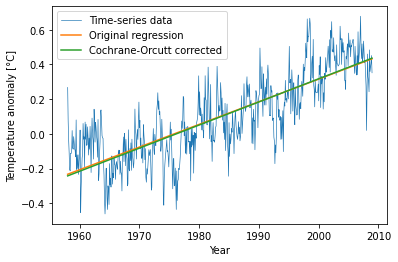

In [11]:
plt.plot(Tm["Time"],Tm["T"],linewidth=0.66,label="Time-series data")
plt.plot(Tm["Time"],m_orig*Tm["t"]+b_orig,label="Original regression")
plt.plot(Tm["Time"],m_corr*Tm["t"]+b_corr,label="Cochrane-Orcutt corrected")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly [°C]")
plt.legend()
plt.show()

## Discussion

1. Temperature anomaly is calculated monthly for each section on a $5^\circ\times5^\circ$ grid across land and ocean surfaces. The historical average temperature of a section (1901-2000, the 20th century average) is subtracted from its most recent average. The grid values are then weighted by area (to reflect the reality that the boxes are smaller near the poles and larger near the equator) and averaged.

2. Global temperature anomaly quantifies how unusual global weather (temperature) for a given time period is relative to the historical global climate (temperature). It is more meaningful than global mean temperature because it normalizes the observed temperature differences to their local expected values. For example, geographical characteristics will dictate what is considered a "high" temperature versus a "low temperature"; the absolute temperature of a "cold" arctic night cannot be compared to that of a tropical rainforest. Global mean temperature erases the existing relativity and artificially compares temperatures on the same scale. Global temperature anomaly accounts and corrects for this.

3. It is important to check that the residuals are independent and random because if they are not, then there is some relation in the data that the model is not identifying, or an apparent trend may appear that is actually just due to the self-dependent nature of the data points.

4. Yes, it is still possible to estimate a trend with confidence. After correcting for autocorrelation of residuals using the Cochrane-Orcutt procedure, the corrected regression still shows a strong trend.

5. 

In [12]:
predicted = m*(2199-1958)+b
min_est = (m-m_err)*(2199-1958) + (b-b_err)
max_est = (m+m_err)*(2199-1958) + (b+b_err)
err = 2*np.mean((predicted-min_est,max_est-predicted)) # multiplied by 2 for 95% confidence
print(f"Predicted warming by year 2199: {predicted:.3f} ± {err:.3f} °C")

Predicted warming by year 2199: 2.967 ± 0.212 °C


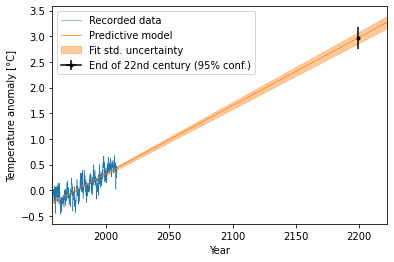

In [13]:
# fig = plt.figure(figsize=(9,6))
x = np.linspace(1958,2222,10)
plt.plot(Tm["Time"],Tm["T"],linewidth=0.5,label="Recorded data")
plt.plot(x,m*(x-1958)+b,linewidth=0.75,label="Predictive model")
plt.fill_between(x, (m-m_err)*(x-1958)+(b-b_err),
                    (m+m_err)*(x-1958)+(b+b_err),
                    color="C1",alpha=0.4,label="Fit std. uncertainty")
plt.errorbar(2199,predicted,yerr=err,xerr=1,marker=".",color="k",label="End of 22nd century (95% conf.)")
plt.xlim(1958,2222)
plt.xlabel("Year")
plt.ylabel("Temperature anomaly [°C]")
plt.legend()
plt.show()

## References

- https://www.ncei.noaa.gov/access/monitoring/faq/anomalies.php

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=385eace9-e066-4866-bb55-3a1ff5bdb476' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>